In [2]:
import matplotlib.pyplot as plt
#sns.set()
import numpy as np
import pandas as pd
import scipy.optimize
import init

In [3]:
class Zero:
    # compound period - how many times a year the i.r. is compounded
    def __init__(self, rate, ttm, face_value = 1, compound_period=1):
        self.rate = rate
        self.compound_period = compound_period
        self.ttm = ttm
        self.face_value = face_value
        self.price = self.get_price(rate)
        #this is always true for zero coupon bonds
        self.YTM = rate
        self.dy = self.get_dy(self.YTM)
        self.DD = self.get_DD(self.YTM)
        self.DV01 = self.get_DV01(self.YTM)
        self.D_mac = self.get_Dmac()
        self.D = self.get_D()
        self.dyy = self.get_dyy(self.YTM)
        self.C = self.get_C()

    def get_price(self, rate):
        discount_factor = (1 + rate/self.compound_period)**(-1 * self.ttm*self.compound_period)
        price = discount_factor * self.face_value
        return price

    def get_dy(self, y):
        return -1 * self.face_value * self.ttm/self.compound_period / (1 + y*self.compound_period)**(self.ttm*self.compound_period + 1)
        
    def get_DD(self, y):
        return self.get_dy(y) * -1

    def get_DV01(self, y):
        return self.get_DD(y) * 1/10_000

    def get_Dmac(self):
        return -1 * self.dy * 1/self.price * (1 + self.YTM*self.compound_period)

    def get_D(self):
        return self.D_mac/(1 + self.YTM*self.compound_period)

    def get_dyy(self, y):
        double_deriv = self.face_value * self.ttm/self.compound_period * (self.ttm/self.compound_period + 1) / (1 + y*self.compound_period)**(self.ttm*self.compound_period + 2)
        return double_deriv

    def get_C(self):
        return self.dyy / self.price


In [4]:
Z_2 = Zero(0.05, ttm=2)

In [5]:
Z_2.price

0.9070294784580498

In practice, the sensitivity that is of most focus is the sensitivity to the yield to maturity of the bond

In [7]:
# we can use a single scaler if all rates are the same
print(f'Yield to Maturity (YTM) of bond: {Z_2.YTM}')

Yield to Maturity (YTM) of bond: 0.05


Since Zero bonds have a single cash flow, their yield to matuirty is the associated spot rate.

We can simplify movements in the term structure by modeling movements in the bonds YTM. First, we observe the price of a bond as a fuction of its YTM:

$$ P(y,T) =  \frac{FV}{(1 + y)^{T_n}},$$

where $FV$ is the face value of the zero. The sensitivy with repect to the yield follows as

$$ \frac{\partial P(y,T)}{\partial y} = -1 *  \frac{FV * T_n}{(1 + y)^{T_n + 1}}.$$

It is important to note that the $y$ defined here is for that period, i.e. annualized YTM per period.

In [10]:
print(f'Derivative of zero price w.r.t yield: {Z_2.dy}.')

Derivative of zero price w.r.t yield: -1.727675197062952.


## Duration

Now that we have our zero's sensitivty to changes in the yield, we can observe the zero's **Duration**. The different duration measures of a zero are very closely related to the sensitivity to shifts in yield.
### Dollar Duration (DV01)

$$ -1 * \frac{1}{10,000}\frac{\partial P(y,T)}{\partial r}$$

In [12]:
print(f'DV01 of zero: {Z_2.DV01}')

DV01 of zero: 0.0001727675197062952


The dollar duration is just the negative of the sensitivty to a bp change. This does nothing other than allow us to think of duration as "amount to lose" instead of "amount to change".

### Macauly Duration

The Macauly Duration is a time weighted average of payments that measures how far in the future a bond is paid off.

$$D_{\text{MAC}} = -1 * \frac{\partial P(y,T)}{\partial y} * \frac{1}{P(y,T)} * (1 + y)$$

In [15]:
print(f'Macauly Duration of bond: {Z_2.D_mac}')

Macauly Duration of bond: 2.0


### Duration (Modified Duration)

The duration is used to approximate the (*minus*) percentage movement in zero price for a 100 bp ($1\%$) change in the yield.

$$ D = -1 * \frac{\partial P(y,T)}{\partial y} * \frac{1}{P(y,T)} = \frac{D_{\text{MAC}}}{1+y}.$$

It is important to note that the "100 bp change" is not observed in the formula, but can be extracted by observing

$$ 
\begin{aligned}
D &= -1 * \left [ \frac{\partial P(y,T)}{\partial y} * \underbrace{0.01}_\text{Sensitivity to 100 bp change} \right ] * \left [ \frac{1}{P(y,T)} * \underbrace{100}_\text{percentage movement} \right ] \\
\\
 &= -1 * \frac{\partial P(y,T)}{\partial y} * \frac{1}{P(y,T)}
\end{aligned}
$$


## Effective Duration

In [17]:
print(f'Duration of bond: {Z_2.D}')

Duration of bond: 1.9047619047619047


### Convexity ($C$)

Moving back to direct sensitivities, convexity of yield changes is another important metric to observe. The convexity is the rate of change of the sensitivity to changes in the yield.

$$ C = \frac{\partial^2 P(y,T)}{\partial y^2} * \frac{1}{P(y,T)}$$

where

$$ \frac{\partial^2 P(y,T)}{\partial y^2} =  \frac{FV * T_n * (T_i + 1)}{(1 + y)^{T_n + 2}}.$$

In [19]:
print(f'Convexity of bond: {Z_2.C}')

Convexity of bond: 5.442176870748299


# Barbell Hedge

Now that we have these metrics for a Zero, we can use them to "immunize" portfolios. Immunization is the technique of holding a portfolio with zero duration (and possibly convexity), and this is helpful by observing the Second-Order Taylor Approximation of movements in a portfolio value with repest to yield:

$$\Delta P \approx -D_PP(\Delta y) + \frac{1}{2}C_PP(\Delta y)^2.$$

From this, we can see the strength in holding an immunized portfolio with $D_p = C_p = 0$. For the following example, let us pretend that we work at a bank, and we have just sold a single 5-year-to-maturty Zero. As good bankers, we want to reduce the volatility of our book as much as possible, we see that 1-year-to-maturity and 10-year-to-maturity bonds are also being traded on the market. Lets see how we can use these two bonds to reduce our risk.

In [21]:
Z_1 = Zero(0.05, ttm=1)
Z_5 = Zero(0.05, ttm=5)
Z_10 = Zero(0.05, ttm=10)

Since our interest rate curve is flat, we can use this derivation of portfolio dollar duration:
$$Z_pD_p = N^1*Z_1*D_1 + N^{10}*Z_{10}*D_{10}$$

So, all we need to do is ensure the following two equalities hold:
$$\begin{aligned}
Z_5 &= N^1*Z_1 + N^{10}*Z_{10}\\
D_5Z_5 &= N^1*Z_1*D_1 + N^{10}*Z_{10}*D_{10}
\end{aligned}$$
$$\downarrow$$
$$
\begin{align}
N^1 = \frac{Z_5(D_5-D_{10})}{Z_1(D_1-D_{10})} && N^{10} = \frac{Z_5(D_1 - D_5)}{Z_{10}(D_1 - D_{10})}
\end{align}$$

In [23]:
N1 = (Z_5.price*(Z_5.D-Z_10.D))/(Z_1.price*(Z_1.D - Z_10.D))
N10 = (Z_5.price*(Z_1.D-Z_5.D))/(Z_10.price*(Z_1.D - Z_10.D))
print(f'Number of 1 year bonds: {N1}')
print(f'Number of 10 year bonds: {N10}')

Number of 1 year bonds: 0.4570569304399344
Number of 10 year bonds: 0.56723625


In [24]:
class Portfolio:
    def __init__(self, bonds, quantities):
        self.YTM = bonds[0].YTM
        self.bonds = bonds
        self.N = quantities
        self.price = self.get_price(self.YTM)
        self.D = self.get_D(self.YTM)
        self.C = self.get_C(self.YTM)

    def get_price(self, y):
        return sum([x.get_price(y)*n[0] for x, n in zip(self.bonds, self.N)])

    def get_D(self, y):
        s = sum([x.D*x.get_price(y)*n[0] for x, n in zip(self.bonds, self.N)])
        return s/self.price
    
    def get_dy(self, y):
        return -1 * self.get_D(y)*self.get_price(y)

    def get_dyy(self, y):
        return self.get_C(y)*self.get_price(y)
   
    def get_C(self, y):
        c = sum([x.C*x.get_price(y)*n[0] for x, n in zip(self.bonds, self.N)])
        return c/self.price

In [25]:
R_1_10 = Portfolio([Z_1, Z_10], np.array([[N1], [N10]]))

In [26]:
R_1_10.D

4.761904761904761

In [27]:
Z_5.D

4.761904761904761

In [28]:
yields = np.arange(0, 0.1, 0.0001)

In [29]:
Z_5_change = np.array([Z_5.get_price(y) for y in yields])
R_1_10_change = np.array([R_1_10.get_price(y) for y in yields])

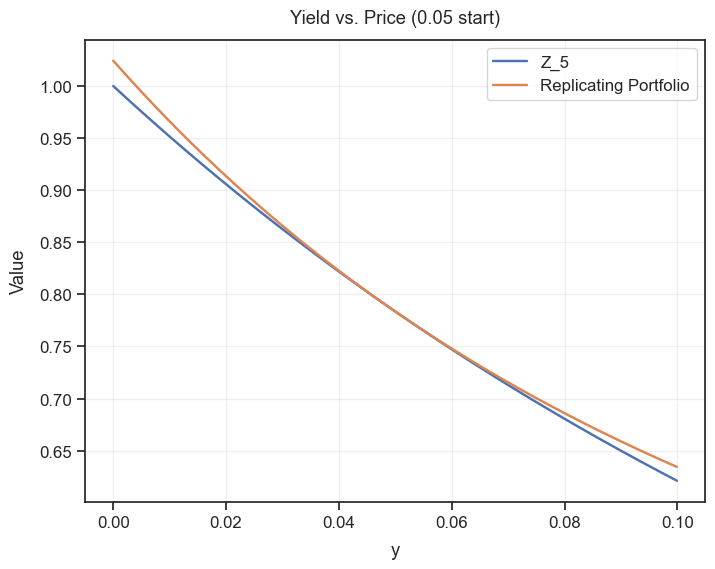

In [30]:
plt.plot(yields, Z_5_change, label = "Z_5")
plt.plot(yields, R_1_10_change, label = "Replicating Portfolio")
plt.legend()
plt.xlabel("y")
plt.ylabel("Value")
plt.title("Yield vs. Price (0.05 start)")
plt.show()

In [31]:
Z_5_dy = np.array([Z_5.get_dy(y) for y in yields])
R_1_10_dy = np.array([R_1_10.get_dy(y) for y in yields])

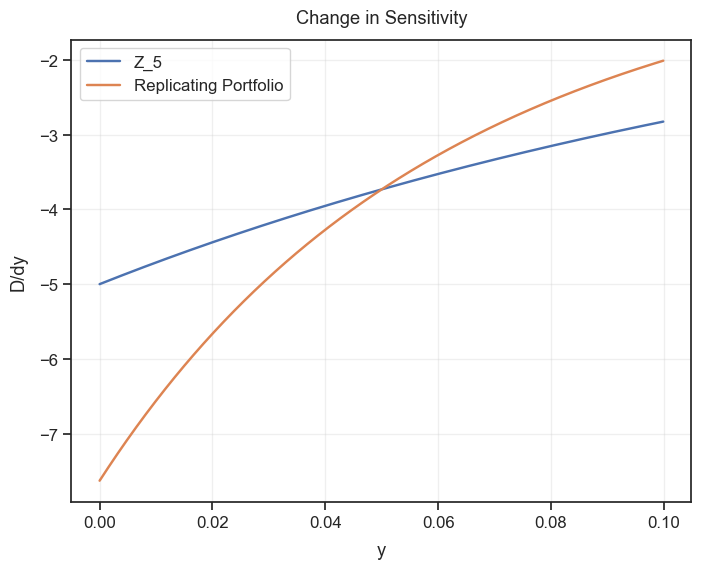

In [32]:
plt.plot(yields, Z_5_dy, label = "Z_5")
plt.plot(yields, R_1_10_dy, label = "Replicating Portfolio")
plt.legend()
plt.xlabel("y")
plt.ylabel("D/dy")
plt.title("Change in Sensitivity")
plt.show()

As we can see, the Value and the Duration of the replicating portfolio and the underlying zero both cost the same and have the same duration. Now we can observe how our book's value will change with yield given we purchase 0.457 1-year-to-maturity and 0.567 10-year-to-maturty for $4.769.

In [34]:
book_v_1_10 = R_1_10_change - Z_5_change

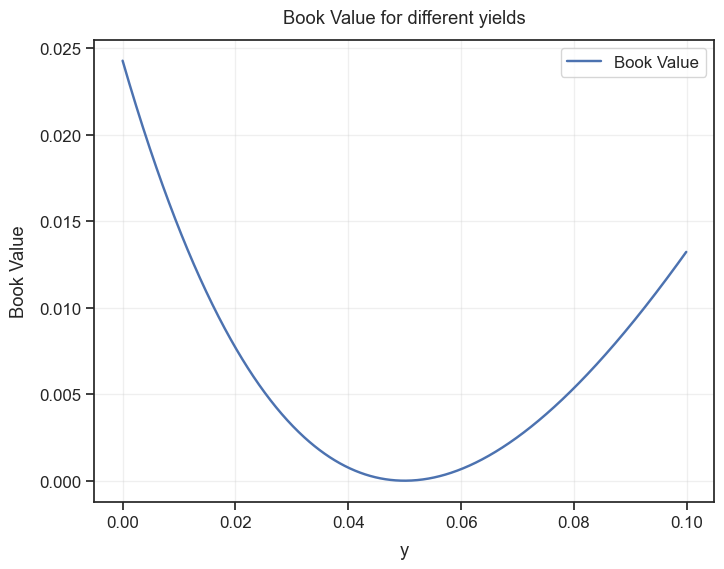

In [35]:
plt.plot(yields, book_v_1_10, label = "Book Value")
plt.legend()
plt.xlabel("y")
plt.ylabel("Book Value")
plt.title("Book Value for different yields")
plt.show()

In [36]:
Z_5_dyy = np.array([Z_5.get_dyy(y) for y in yields])
R_1_10_dyy = np.array([R_1_10.get_dyy(y) for y in yields])

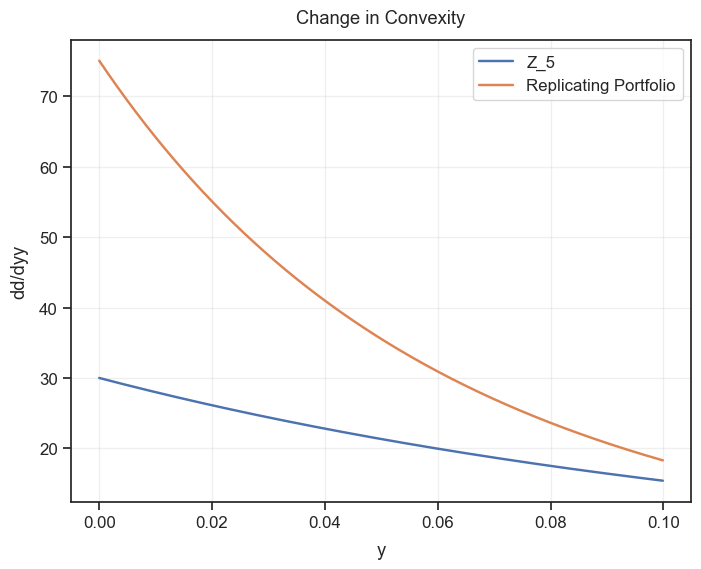

In [37]:
plt.plot(yields, Z_5_dyy, label = "Z_5")
plt.plot(yields, R_1_10_dyy, label = "Replicating Portfolio")
plt.legend()
plt.xlabel("y")
plt.ylabel("dd/dyy")
plt.title("Change in Convexity")
plt.show()

## Convexity Hedging

If we want the convexity of our replicating portfolio to match the convexity of $Z_5$, we need a third bond in our replicating portfolio.

In [39]:
Z_2.price

0.9070294784580498

Now, we can solve for the portfolio value, duration, and convexity. For simplicity, we can take a matrix approach to solving for the portfolio weights:
$$
 \begin{bmatrix}
Z_5 \\
D_5Z_5 \\
C_5Z_5
\end{bmatrix}
=\begin{bmatrix}
Z_1 & Z_2 & Z_{10} \\
D_1Z_1 & D_2Z_2 & D_{10}Z_{10} \\
C_1Z_1 & C_2Z_2 & C_{10}Z_{10} \\
\end{bmatrix} 
\begin{bmatrix}
N^1 \\
N^2 \\
N^{10}
\end{bmatrix} 
$$
$$\downarrow$$
$$
\begin{bmatrix}
N^1 \\
N^2 \\
N^{10}
\end{bmatrix} 
= \begin{bmatrix}
Z_1 & Z_2 & Z_{10} \\
D_1Z_1 & D_2Z_2 & D_{10}Z_{10} \\
C_1Z_1 & C_2Z_2 & C_{10}Z_{10} \\
\end{bmatrix}^{-1}
 \begin{bmatrix}
Z_5 \\
D_5Z_5 \\
C_5Z_5
\end{bmatrix}
$$

In [41]:
A = np.array([[Z_1.price, Z_2.price, Z_10.price],
              [Z_1.D * Z_1.price, Z_2.D * Z_2.price, Z_10.D * Z_10.price],
              [Z_1.C * Z_1.price, Z_2.C * Z_2.price, Z_10.C * Z_10.price],
             ])

a = np.array([[Z_5.price],
              [Z_5.D * Z_5.price],
              [Z_5.C * Z_5.price]
             ])

N = np.linalg.inv(A) @ a

In [42]:
R_1_2_10 = Portfolio([Z_1, Z_2, Z_10], N)

In [43]:
R_1_2_10.price

0.7835261664684602

In [44]:
Z_5.price

0.7835261664684589

In [45]:
R_1_2_10_change = np.array([R_1_2_10.get_price(y) for y in yields])

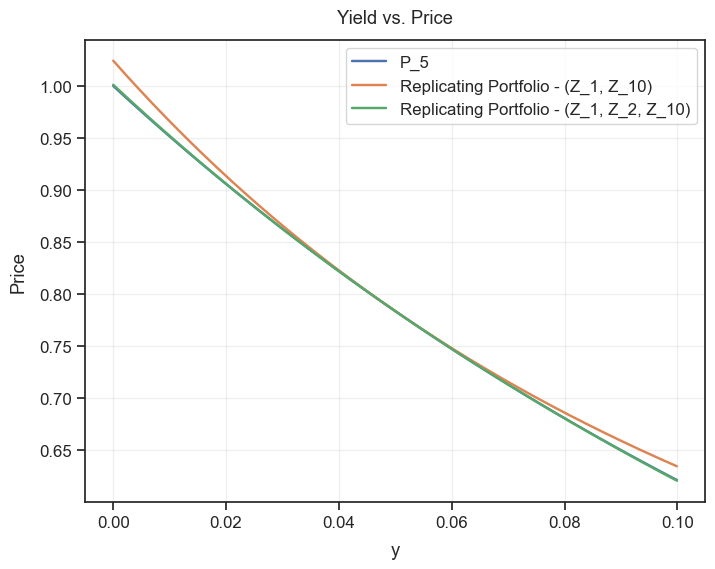

In [46]:
plt.plot(yields, Z_5_change, label = "P_5")
plt.plot(yields, R_1_10_change, label = "Replicating Portfolio - (Z_1, Z_10)")
plt.plot(yields, R_1_2_10_change, label = "Replicating Portfolio - (Z_1, Z_2, Z_10)")
plt.legend()
plt.xlabel("y")
plt.ylabel("Price")
plt.title("Yield vs. Price")
plt.show()

In [47]:
R_1_2_10_dy = np.array([R_1_2_10.get_dy(y) for y in yields])

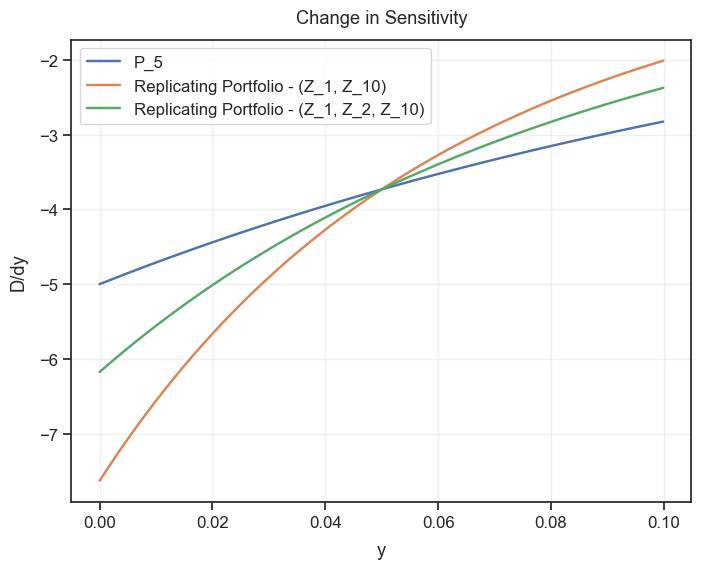

In [48]:
plt.plot(yields, Z_5_dy, label = "P_5")
plt.plot(yields, R_1_10_dy, label = "Replicating Portfolio - (Z_1, Z_10)")
plt.plot(yields, R_1_2_10_dy, label = "Replicating Portfolio - (Z_1, Z_2, Z_10)")
plt.legend()
plt.xlabel("y")
plt.ylabel("D/dy")
plt.title("Change in Sensitivity")
plt.show()

In [49]:
R_1_2_10_dyy = np.array([R_1_2_10.get_dyy(y) for y in yields])

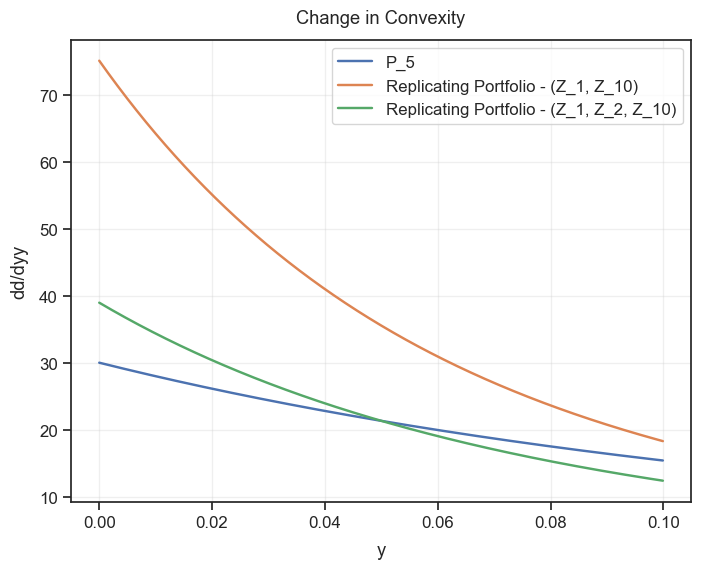

In [50]:
plt.plot(yields, Z_5_dyy, label = "P_5")
plt.plot(yields, R_1_10_dyy, label = "Replicating Portfolio - (Z_1, Z_10)")
plt.plot(yields, R_1_2_10_dyy, label = "Replicating Portfolio - (Z_1, Z_2, Z_10)")
plt.legend()
plt.xlabel("y")
plt.ylabel("dd/dyy")
plt.title("Change in Convexity")
plt.show()

In [51]:
book_v_1_2_10 = R_1_2_10_change - Z_5_change

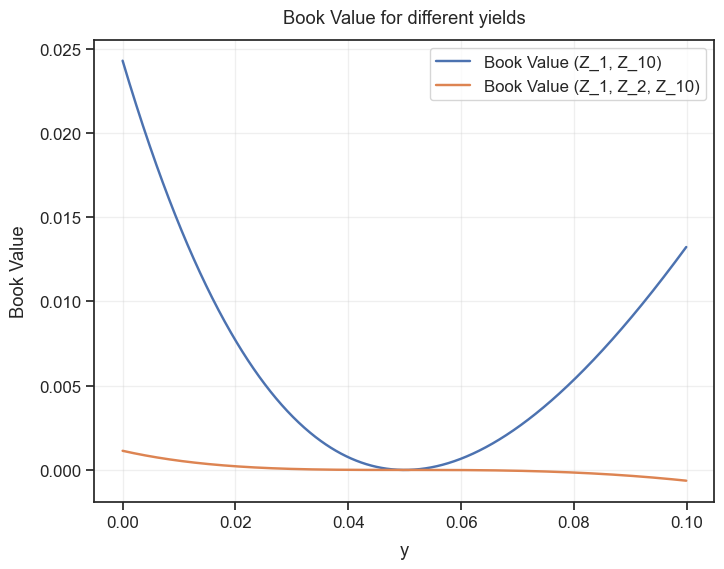

In [52]:
plt.plot(yields, book_v_1_10, label = "Book Value (Z_1, Z_10)")
plt.plot(yields, book_v_1_2_10, label = "Book Value (Z_1, Z_2, Z_10)")
plt.legend()
plt.xlabel("y")
plt.ylabel("Book Value")
plt.title("Book Value for different yields")
plt.show()